# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Kristoffer Landsnes & Arthur ...
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [204]:
import tarfile
import os
import cv2
import numpy as np
import skimage.segmentation as seg
import skimage.color as color
from skimage.measure import label, regionprops, find_contours
import pprint


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

## 1.1 Brain image visualization

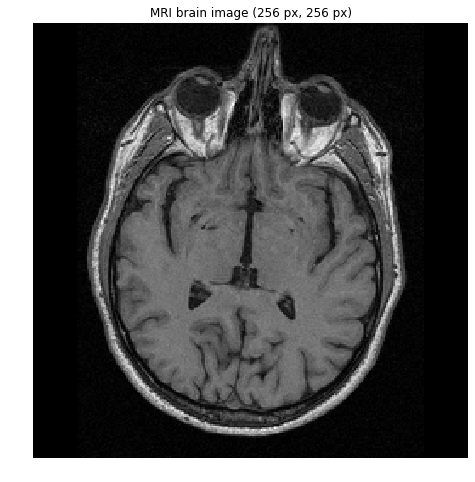

In [96]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

## 1.2 Region growing



## Implementation of region growing

We implemented region growing using **4-connectivity** to find the neighbors of a pixel and a **pixel value threshold as a homogeneity criterion**.

To choose the seed, we made the assumption that the brain would roughly be located in the center of the image.

### REGION GROWING USING THRESHOLD

In [139]:
def get_neighbors(px, img):
    """return list of the 4-connected neighbors of px (x,y) in img"""

    px_x, px_y = px[0], px[1]
    height = len(img)
    width = len(img[0])
    
    # Check that px is within the bounds of the img
    assert px_x < height
    assert px_y < width
    
    neighbors = []
    
    # North-West
    if px_x > 0 and px_y > 0:
        neighbors.append((px_x - 1, px_y - 1))
            
    # North
    if px_x > 0:
        neighbors.append((px_x - 1, px_y))
        
    # North-East
    if px_x > 0 and px_y < width:
        neighbors.append((px_x - 1, px_y + 1))
            
    # West
    if px_y > 0:
        neighbors.append((px_x, px_y - 1))

    # East
    if px_y < width:
        neighbors.append((px_x, px_y + 1))
            
    # South-West
    if px_x < height and px_y > 0:
        neighbors.append((px_x + 1, px_y - 1))
            
    # South
    if px_x < height:
        neighbors.append((px_x + 1, px_y))
            
    # South-East
    if px_x < height and px_y < width:
        neighbors.append((px_x + 1, px_y + 1))
            
    return neighbors

In [140]:
def get_thresholded_neighbors(th, px, img):
    "returns a list of the neighbors of px (x,y) in img whose px_value is above a threshold"
    neighbors = get_neighbors(px, img)
    good_neighbords = []
    
    for px in neighbors:
        if img[px] > th:
            good_neighbords.append(px)
        
    return good_neighbords

In [143]:
def region_growing(seed, th, img):
    "region growing using the pixel_value > threshold as a homogeneity criterion"
    seed_x, seed_y = seed
    height = len(img)
    width = len(img[0])
    
    # Check that the seed is within the bounds of the img
    assert seed_x < height
    assert seed_y < width
    
    # labeled_img[x][y] if the (x,y) pixel hasn't been visited yet,
    # 1 if it has been visited and is ABOVE th
    # -1 if it has been visited and is BELOW th
    labeled_img = np.zeros((height, width))
    
    # list of the pixels left to visit
    px_to_visit = [(seed_x, seed_y)]
    
    for px in px_to_visit:
        
        if labeled_img[px] == 0:
            # see if px belongs to the region
            if img[px] > th:
                labeled_img[px] = 1
                # add the neighbors of px to the px_to_visit if they should be added
                px_to_visit.extend(get_thresholded_neighbors(th, px, img))
            else:
                labeled_img[px] = -1    
        
    return labeled_img

In [175]:
def compute_size(bw_img):
    """
    Return the size of all the pixel with a value of 1 in the bw_img
    """
    count = 0
    for x in bw_img.ravel():
        if x == 1:
            count = count + 1
    return count

# Results of Region Growing

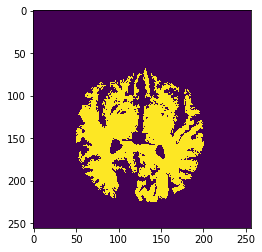

In [177]:
seed = (100,100) # roughly in the center of the picture
threshold = 69  # 69 has been set empirically
segmented_brain = region_growing(seed, threshold, brain_im)
plt.imshow(segmented_brain)


In [181]:
# Hence the size of the brain is the sum of all the pixels in the grown regions
print("There are " + str(compute_size(segmented_brain)) + " pixels in the brain") 

There are 12062 pixels in the brain


# Discussion of Region Growing

While giving favorable result when the seed and threshold are well chosen, chosing them can not be easy and the result is highly sensitive to these parameters.

It can also be noted that no threshold was able to correctly assess the lower part of the brain as being "brain tissue". The size in pixels given by the region growing is therefore an underestimate of the actual size.

## Sensitivity to the seed

As can be seen below, a change in the seed of 5 px in both direction can drastically alter the results.

This comes from the fact that having a different seed means growing a different region.

In the case of the (95, 95) seed, the seed simply did not pass the homogeneity criterion, and therefore no region growth could happen, resulting in a 0 pixel brain size

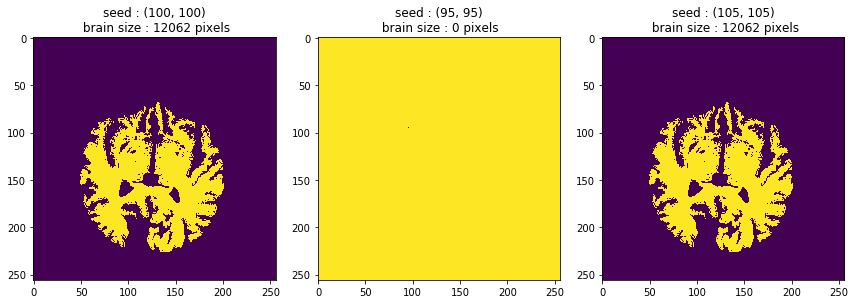

In [259]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

threshold = 69  # 69 has been set empirically
for seed, ax in zip([(100,100), (95,95), (105,105)], axes.ravel()):
    segmented_brain = region_growing(seed, threshold, brain_im)
    ax.imshow(segmented_brain)
    ax.set_title("seed : " + str(seed) + "\n brain size : " + str(compute_size(segmented_brain)) + " pixels" )
fig.tight_layout()

## Sensitivity to the threshold

As can be seen below, picking a different threshold can greatly alter the results.

Even an offset of 1 in the threshold can allow the region to grow beyong what we wanted to segment (or to the contrary, prevent it to grow as far as we wanted it to)

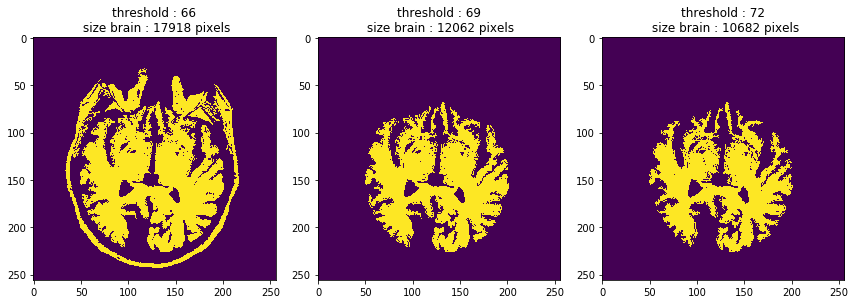

In [187]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

seed = (100, 100) 
for t, ax in zip([66, 69, 72], axes.ravel()):
    segmented_brain = region_growing(seed, t, brain_im)
    ax.imshow(segmented_brain)
    ax.set_title("threshold : " + str(t) + "\n size brain : " + str(compute_size(segmented_brain)) + " pixels" )
fig.tight_layout()

## 1.3 Contour detection

For the contour detection we will use active contours, in particular the snake algorithm. 
Firstly we define a circle function, to more easily enclose the brain area. 

In [188]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    """
    Function to facilitate ploting of images
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.
    center := center of the circle in pixels
    radius := radius of the circle in pixels
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

## Initial attempt - Snake algorithm 
For the initial run we have tested the active contour built-in function, of the `skimage.segmentation` library. Without any filtering or preprocessing of the image, we can see the snake struggles to generalize around the brain tissue. 
This is the case, even after tuning the parameters of the function. In essence, this includes: 
* beta - the smoothness of the snake 
* w_line - the attraction towards brightness (negative values, attracts towards darkness or imagined edges between brain and skull) 
* w_edge - the edge attraction ( positive values attracts to edges)

What should be noticed here is that the circular-shape of the brain actually makes it possible to estimate the brain area, just with the initial circle used in the active contour algorithm. This is shown below. 

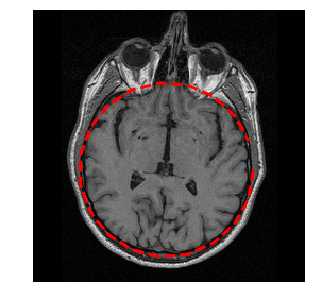

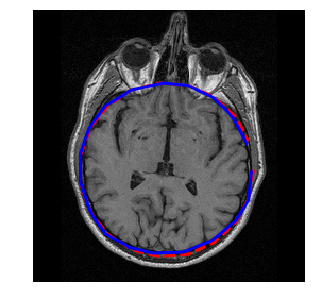

In [197]:
###### INITIAL RUN  #######

radius_init = 82
centre_init = [150,125]
resolution_init = 20

# Generate circle points
points = circle_points(resolution_init,centre_init,radius_init)[:-1]

# Plot brain and circle points
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

image_gray = color.rgb2gray(brain_im)

# Create active contour starting at the circle points - parameters tuned
snake = seg.active_contour(image_gray, points, beta=0.1,w_line=-6.0, w_edge=10)

# Plot the circle points and the resulting active contour
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# Discussion of the initial attempt

The issue with the snake algorithm is that it needs a starting position (in our case a circle).

The radius (as well as the center) of this circle influences greatly the end result, as can be seen below. The initial radius affects the snake so much that the area instead the snake can be approximated by the area of the initial circle, and hence there is no use for the snakes.

Another issue is that the snake is not able to discriminate inside the brain (the folds), overestimating the total brain size.

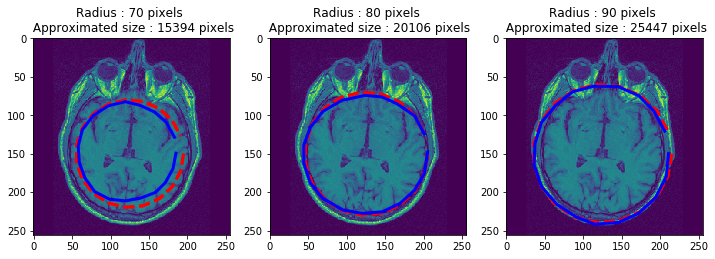

In [258]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

centre_init = [150,125]
resolution_init = 20
for ax, r in zip(axes.ravel(), [70, 80, 90]):
    # plot brain
    ax.imshow(brain_im)

    # Generate circle points
    points = circle_points(resolution_init,centre_init,r)[:-1]

    # Plot brain and circle points
    ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

    image_gray = color.rgb2gray(brain_im)

    # Create active contour starting at the circle points - parameters tuned
    snake = seg.active_contour(image_gray, points, beta=0.1,w_line=-6.0, w_edge=10)

    # Plot the circle points and the resulting active contour
    ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
    
    ax.set_title('Radius : ' + str(r) + " pixels \n Approximated size : " + str(round((np.pi)*r**2)) + " pixels")

# 1.4 Additional method(s)

We will try several additional methods :
* **Thresholding, and then applying region detection.** We can then discriminate the different detected regions by area, assuming that the biggest area should be the brain

* **Filtering using kernels** to detect the edges


# 1.4.1 Thresholding and region detection

In [268]:
def threshold(im, t1, t2):
    """
    Function thresholding an image, im,  between [t1,t2]
    Return the thresholded image
    """
    im_threshold = im.copy()
    im_threshold[im_threshold<t1] = 0
    im_threshold[im_threshold>t2] = 0
    im_threshold[(im_threshold>=t1) & (im_threshold<=t2)] = 255
    return im_threshold

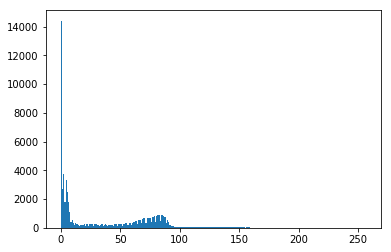

In [269]:
# Histogram thresholding for identifying the brain area and better choose the threshold
brain_hist = plt.hist(brain_im.ravel(), 256,[0,256])


In [315]:
def get_brain(brain_im):
    """
    Return the labeled_im as well as the largest region found when labelling and segmenting.
    This should be the brain
    """
    labeled_im = skimage.measure.label(brain_im, background=0)
    regions = regionprops(labeled_im)
    
    max_area = 0
    max_area_region = None
    for r in regions:
        if r.area > max_area:
            max_area = r.area
            max_area_region = r
    return labeled_im, max_area_region 

Text(0.5, 1.0, 'brain \n brain size : 14431 pixels')

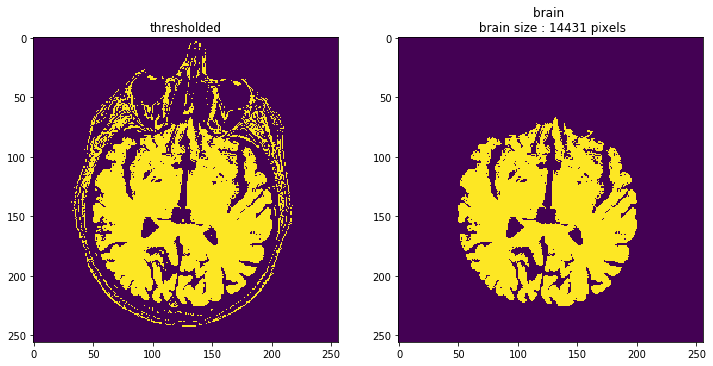

In [329]:
# Arbitrary values
t1 = 64
t2 = 100

thresh = threshold(brain_im, t1, t2)
labeled_im, brain_region = get_brain(thresh)

brain = labeled_im.copy()
a = np.array(labeled_im)
a[a!=brain_region.label] = 0

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(thresh)
axes[0].set_title("thresholded")
axes[1].imshow(a)
axes[1].set_title("brain \n brain size : " + str(brain_region.area) + " pixels")

# Result of thresholding and region detection

This method seems so far to be the best one. 

Looking at the histogram, we knew that the brain tissue had pixel values ranging from roughly 50 to 100. We then empirically found the threshold values we settled for.

We then label the image, and use region detection to detect the brain.

This approach is very similar to region growing, although it requires two thresholds (lower and higher). Another difference is that the labelling method used used connectivity solely to agregate the pixels together into regions, not a threshold criterion as we did with region growing.

The advantage is that it allows us to segment the lower part of the brain (especially the lower left), which we were **not** able to do with region growing.

The disadvantage is that it is very sensible to the thresholds chosen, as we can see below

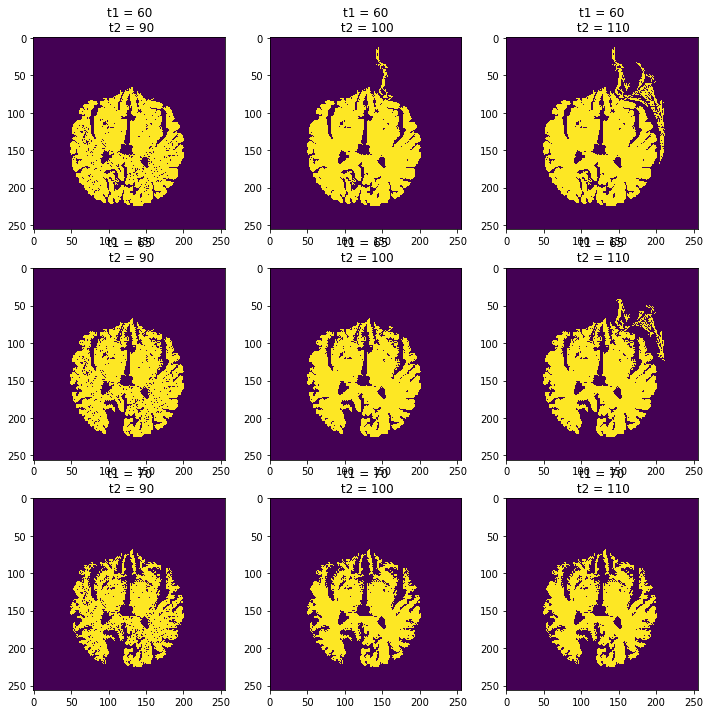

In [332]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))


for i, t1 in enumerate([60, 65, 70]):
    for j, t2 in enumerate([90, 100, 110]):
        thresh = threshold(brain_im, t1, t2)
        labeled_im, brain_region = get_brain(thresh)

        brain = labeled_im.copy()
        a = np.array(labeled_im)
        a[a!=brain_region.label] = 0
        
        axes[i][j].imshow(a)
        axes[i][j].set_title("t1 = " + str(t1) + "\n t2 = " + str(t2))
        
    
    

# 1.4.2 Filtering to detect the edges

Text(0.5, 1.0, 'hildreth')

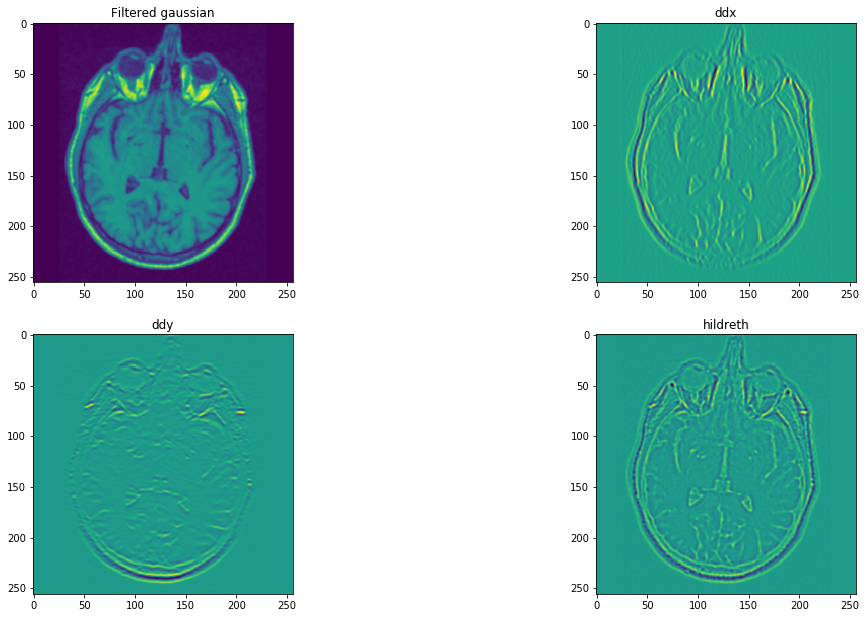

In [110]:
# Marr-Hildreths method 
def gaussian_filter(fSize, fSigma):
    x, y = np.mgrid[-fSize//2 + 1:fSize//2 + 1, -fSize//2 + 1:fSize//2 + 1]
    #print(x)
    g = np.exp(-((x**2 + y**2)/(2.0*fSigma**2)))
    return g/g.sum()


gaus = gaussian_filter(3,2)
filtered_brain = cv2.filter2D(brain_im, -1, gaus)

#Compute gradient in x-direction of picture
brain_dx = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
brain_ddx = cv2.Sobel(np.float32(brain_dx), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
#Compute gradient in y-direction
brain_dy = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,0,1) #Last two numbers = dx, dy 
brain_ddy = cv2.Sobel(np.float32(brain_dy), cv2.CV_32F,0,1) #Last two numbers = dx, dy 

brain_hildreth = brain_ddy + brain_ddx

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.set_size_inches(18.5, 10.5)
axes[0][0].imshow(filtered_brain)
axes[0][0].set_title('Filtered gaussian')
axes[0][1].imshow(brain_ddx)
axes[0][1].set_title('ddx')
axes[1][0].imshow(brain_ddy)
axes[1][0].set_title('ddy')
axes[1][1].imshow(brain_hildreth)
axes[1][1].set_title('hildreth')
#gaus_img = skimage.filters.gaussian(brain_im, sigma=3)
#plt.imshow(gaus_img, cmap=plt.cm.gray)


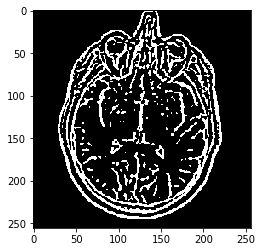

In [111]:
retval, thresholded = cv2.threshold(brain_hildreth, 180, 200, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap = plt.cm.gray)


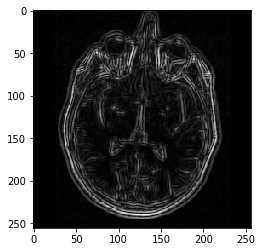

In [112]:
#calculate magnitude 
#ACTIVE CONTOURS 
#FIND CONTOURS - DELETE SOME OF SKULL / EYES - AREA OF CONTOURS(?)
#
grad_mag = np.sqrt(brain_ddx**2 + brain_ddy**2)
plt.imshow(grad_mag, cmap = plt.cm.gray)

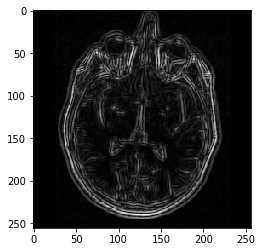

In [113]:
#calculate magnitude 
#ACTIVE CONTOURS 
#FIND CONTOURS - DELETE SOME OF SKULL / EYES - AREA OF CONTOURS(?)
#
grad_mag = np.sqrt(brain_ddx**2 + brain_ddy**2)
plt.imshow(grad_mag, cmap = plt.cm.gray)

# Results of filtering to detect the edges

Unfortunately, the detected edges were too convoluted and on top of each other to be able to extract them and compute the brain size. This method was therefore judged inconclusive.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$recall = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [118]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


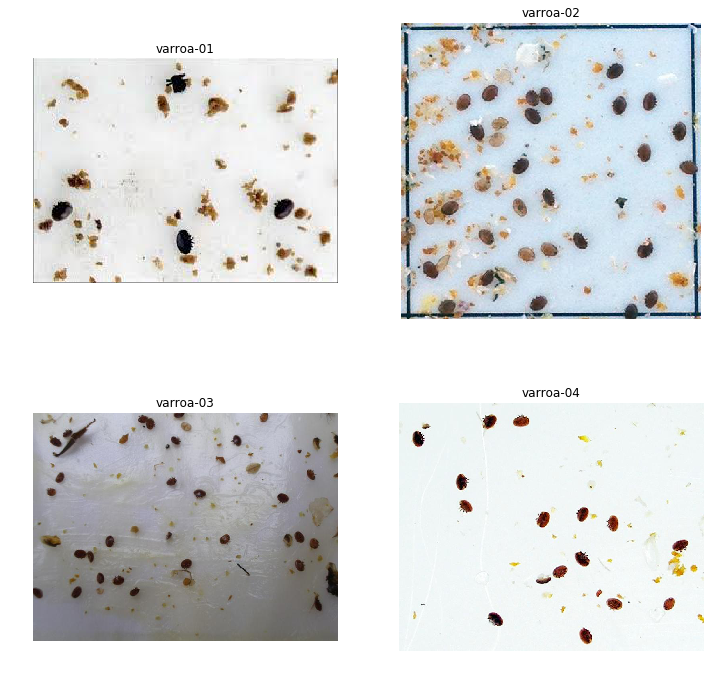

In [119]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [120]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [121]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

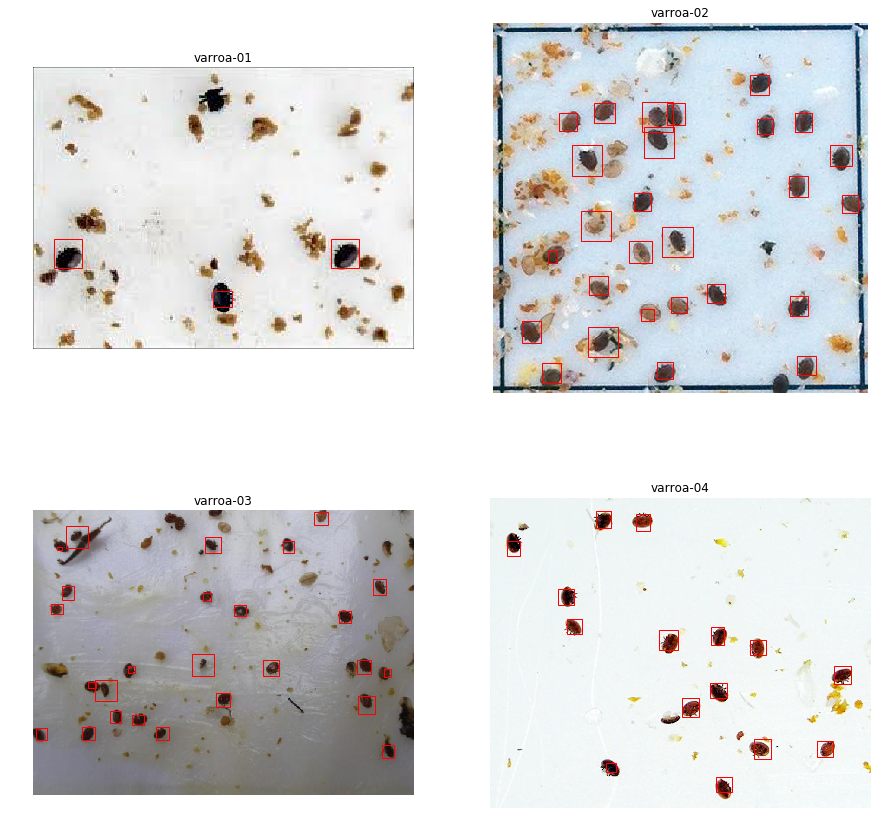

In [122]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

# 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

## Implementation of 2.2 :

In order to count the number of Varroa on each picture, we designed the `find_creatures(...)` function, which takes an input RGB image (as well as some facultative parameters) and returns a thresholded image as well as a list of regions that the algorithm considers to be Varroa.

We start by taking an RGB image and **threshold** it using the minimum method. 
The minimum method works by computing the histogram of the RGB image, smoothing it until there are only two maxima, and then the minimum in between is set as the threshold value.

The pixel value of the background varies throughout each four images. We however except to always have a majority of background pixels (compared to the amount of varroa/bee pixels). This supports thatthis thresholding method works well in both 4 cases.

We then **label** it, and **compute the regionprops** (which gives us a list of regions with descriptors) of the labeled image, allowing us to have access to a large variety of descriptors that we can use to further discriminate each region.

We first take advantage of the fact that the Varroa are, amongst the things that can be detected on the thresholded image, on the bigger side. We do this by **getting rid of all the labels whose area is smaller than average**.

We then take advantage of the fact that the Varroa are roughly globular. We do this by **getting rid of all the labels whose eccentricity is lower than some arbitrary value**. The eccentricity is the one of the ellipse whose second-moments is the same as the as the region's.

We then take advantage of the facts that, within one picture, all the Varroa are roughly the same size. We do this by computing the average area of the remaining regions, and **only keep those whose area is within some arbitrary bounds of this average**.

This allows us to obtain fairly good results using the same routine with the same parameters for the four pictures.

In [123]:
def find_creatures(im, 
                   max_eccentricity=0.95, 
                   margin=0.7):
    """
    Take a RGB image,
    threshold it using (minimum algo)
    Label the thresholded images.
    Then disregard the labels whose px count is lower than average
    Then disregard the labels whose eccentricty is lower than max_eccentricity
    Then disregard the labels whose px count isn't within 
    (current_average*(1-margin); current_average*(1+margin))
    Return the thresholded image and a list of the regions of the found creatures
    """
    
    # Convert RGB to GRAYSCALE
    gray_im = color.rgb2gray(im)

    # Threshold determination
    thresh = skimage.filters.threshold_minimum(gray_im)

    # Thresholding
    binary = gray_im > thresh

    # Label the thresholded image 
    labeled_im = skimage.measure.label(binary, background=True)
    
    # List the different labels that aren't the background
    labels = np.unique(labeled_im[labeled_im!=0])
    
    # The "good" regions are the regions that the algorithm 
    # identifies as Varroa. It is prunes as the algorithm goes on
    good_regions = regionprops(labeled_im)
    
    # Find average area
    areas = []
    for region in good_regions:
        areas.append(region.area)
    avg_area = np.mean(areas)
    
    # Keep the regions with area higher than average
    tmp_good_regions = []
    for region in good_regions:
        if region.area > avg_area:
            tmp_good_regions.append(region)
    good_regions = tmp_good_regions
    
    # Only keep the regions that aren't too elongated
    tmp_good_regions = []
    for region in good_regions:
        if region.eccentricity < max_eccentricity:
            tmp_good_regions.append(region)
    good_regions = tmp_good_regions
    
    # Find average area of the good regions
    areas = []
    for region in good_regions:
        areas.append(region.area)
    new_avg_area = np.mean(areas)
    
    # Only keep the regions whose area are within some arbitrary bounds
    tmp_good_regions = []
    for region in good_regions:
        if (region.area/new_avg_area > 1 - margin) and (region.area/new_avg_area < 1 + margin):
            tmp_good_regions.append(region)
    good_regions = tmp_good_regions
    
    return binary, good_regions

## Results of 2.2

We can know compute the Varroa count for each image.

For an easier understanding of the results, we plot the **RGB image** on which we **highlight the ground truth** and the **detected Varroa**, alongside the **thresholded image** on which we **highlight the detected Varroa**

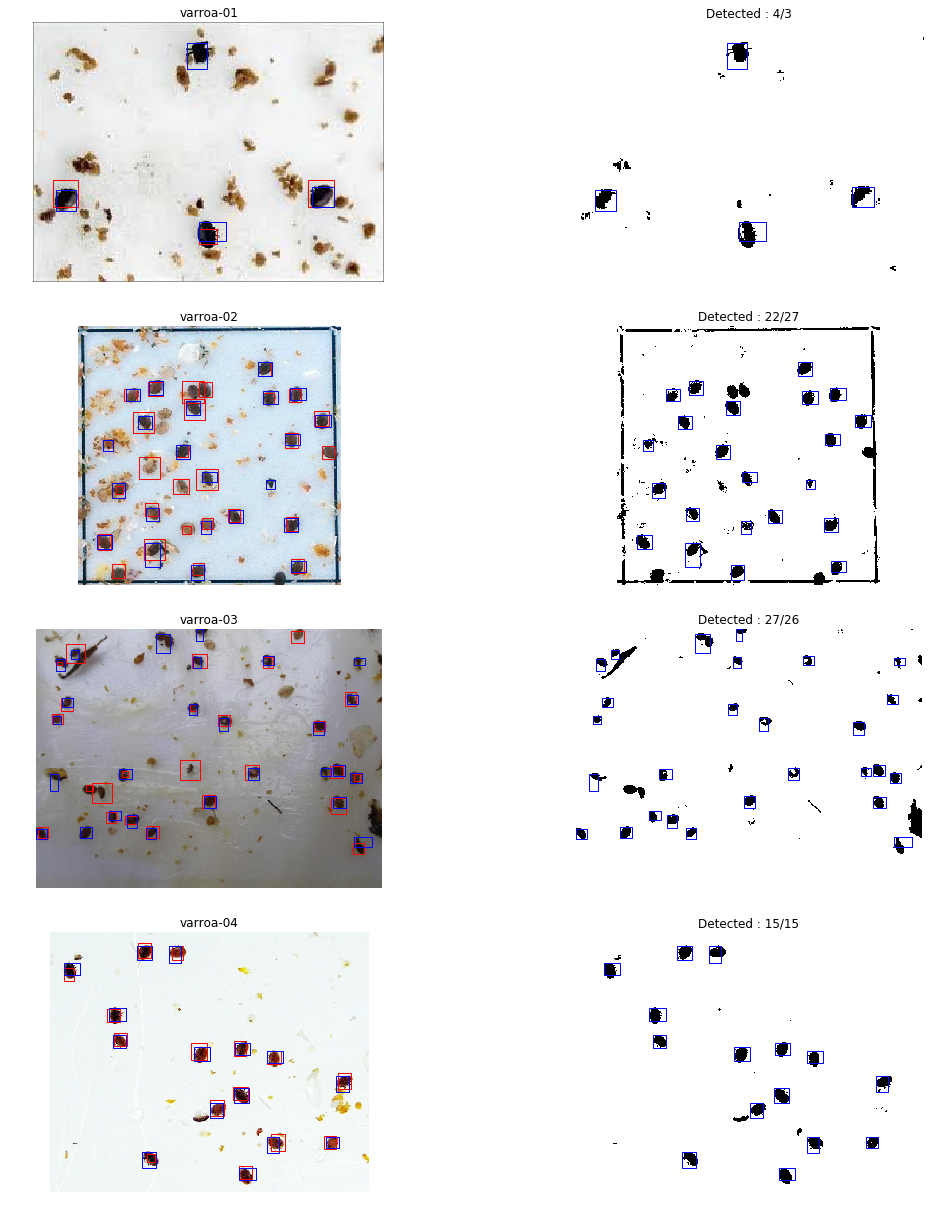

In [124]:
fig, axes = plt.subplots(4, 2, figsize=(17, 17))

for i, im, annotations, img_name in zip(range(0,4), ic, annotations_xmls, im_names):
    binary, regions = find_creatures(im)
    
    # Plot RGB image
    axes[i][0].imshow(im)
    axes[i][0].axis('off')
    axes[i][0].set_title(img_name)
    
    # Superpose the ground truth on RGB
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        axes[i][0].add_patch(rect)

    # Superpose the prediction on RGB
    for r in regions:
        bbox = [r['bbox'][0], 
                r['bbox'][1],
                r['bbox'][2] - r['bbox'][0],
                r['bbox'][3] - r['bbox'][1]]
        rect = patches.Rectangle((bbox[1], 
                                  bbox[0]), 
                                  bbox[2], 
                                  bbox[3],
                                  linewidth=1,edgecolor='b',facecolor='none')
        axes[i][0].add_patch(rect)
    
    # Plot binary
    count = len(regions)
    title = "Detected : " + str(count) + "/" + str(len(annotations))
    axes[i][1].imshow(binary, cmap='gray')
    axes[i][1].axis('off')
    axes[i][1].set_title(title)
    
    # Superpose the prediction on binary
    for r in regions:
        bbox = [r['bbox'][0], 
                r['bbox'][1],
                r['bbox'][2] - r['bbox'][0],
                r['bbox'][3] - r['bbox'][1]]
        rect = patches.Rectangle((bbox[1], 
                                  bbox[0]), 
                                  bbox[2], 
                                  bbox[3],
                                  linewidth=1,edgecolor='b',facecolor='none')
        axes[i][1].add_patch(rect)
    
    
fig.tight_layout()
plt.show()

## Discussion about the results of 2.2

### varroa-01

The background is fairly homogeneous and white, while the Varroas are big, black and separated from each other. This makes for easy segmentation. However, our algorithm finds 4 Varroa while the ground truth tells us there are only 3. By visual inspection, we believe that there are indeed 4 Varroa on that picture, and that the upper black bug is a Varroa.


### varroa-02

There are many Varroa on that picture (27), some of which are laying very close to each other, and others are cutting with some kind of black frame drawn on the background.

Using the assumption that the Varroa are fairly globular, we can avoid several false positives in this picture. This can be seen in the cell below, where when setting the eccentricity to its max value (i.e. 1), we segment some of the drawn lines.

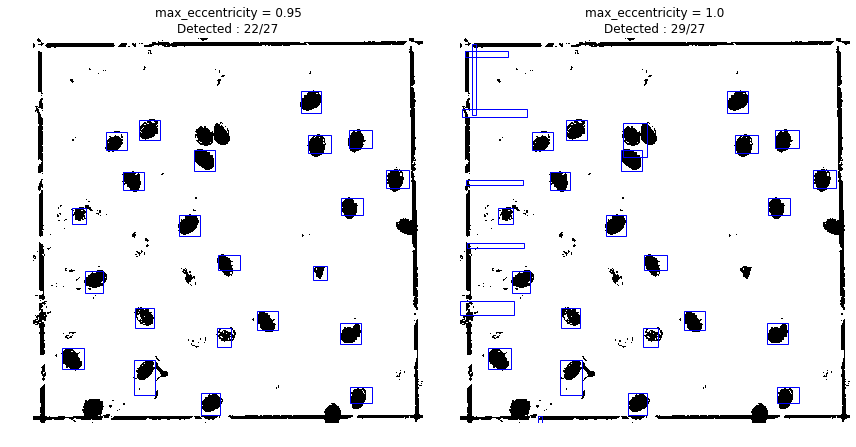

In [125]:
img_idx = 1
img = ic[img_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

for i, e in zip([0, 1], [0.95, 1.0]):
    binary, regions = find_creatures(img, max_eccentricity = e)

    # Plot binary
    count = len(regions)
    axes[i].imshow(binary, cmap='gray')
    axes[i].axis('off')
    detected_title = "Detected : " + str(count) + "/" + str(len(annotations_xmls[img_idx]))
    axes[i].set_title("max_eccentricity = " + str(e) + "\n" + detected_title)

    # Superpose the prediction on top of binary
    for r in regions:
        bbox = [r['bbox'][0], 
                r['bbox'][1],
                r['bbox'][2] - r['bbox'][0],
                r['bbox'][3] - r['bbox'][1]]
        rect = patches.Rectangle((bbox[1], 
                                  bbox[0]), 
                                  bbox[2], 
                                  bbox[3],
                                  linewidth=1,edgecolor='b',facecolor='none')
        axes[i].add_patch(rect)

plt.tight_layout()
plt.show()

### varroa-03

While having a darker background that the other 3 pictures, its pixel value is fairly homogeneous. The issue of the darker background is therefore taken care off when thresholding the picture. A challenge with this picture is the large chunk (lower right corner), as well as two very close together Varroa 

Using a margin of 0.7 allows us to **get rid of the large chunk (lower right corner)**.

It is also interesting to notice that the **two very close Varroa** that were not detected by the algorithm (when margin = 0.7) because, since they were touching, it considered them as one and only one big Varroa, is detected (when margin = 9), but as one (and only one) Varroa.

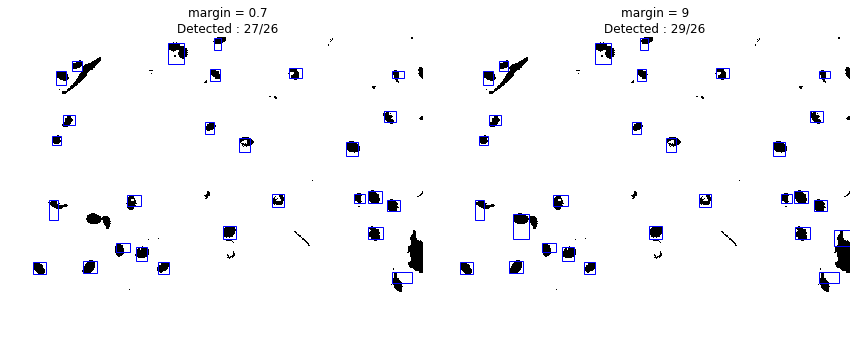

In [126]:
img_idx = 2
img = ic[img_idx]

### CHANGE MARGIN
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
for i, m in zip([0, 1], [0.7, 9]):
    binary, regions = find_creatures(img, margin = m)

    # Plot binary
    count = len(regions)
    axes[i].imshow(binary, cmap='gray')
    axes[i].axis('off')
    detected_title = "Detected : " + str(count) + "/" + str(len(annotations_xmls[img_idx]))
    axes[i].set_title("margin = " + str(m) + "\n" + detected_title)

    
    # Superpose the prediction on RGB
    for r in regions:
        bbox = [r['bbox'][0], 
                r['bbox'][1],
                r['bbox'][2] - r['bbox'][0],
                r['bbox'][3] - r['bbox'][1]]
        rect = patches.Rectangle((bbox[1], 
                                  bbox[0]), 
                                  bbox[2], 
                                  bbox[3],
                                  linewidth=1,edgecolor='b',facecolor='none')
        axes[i].add_patch(rect)
plt.tight_layout()
plt.show()


### varroa-04

The background is clear and uniform. The Varroa are many, very dark and not touching each other. Given how "ideal" this image is, a 100% detection rate was to expect.

# 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

## Outline of the implementation of 2.3 :

In order to compute the IOU of a Varroa, we will compare the **bounding box** (refered to as **bbox**) that is given to us by the ground truth with the **bounding box** that we find through our segmentation algorithm.

Our segmentation algorithm gives us a list of bboxes, one for each Varroa that has been segmented.

In order to compute the IOU of a Varroa's predicted bbox, we need to find its matching ground truth bbox. 

To do that, we select the ground truth bbox that has the **biggest overlap** with our predicted bbox. If our predicted bbox overlaps with no ground truth bbox, we consider the predicted bbox as a false positive.

In [127]:
def get_iou(ground_truth_bbox, our_bbox):
    """
    ground_truth_bbox is a list of the like : [xmin, ymin, width, heigth]
    our_bbox is a list of the like : [xmin, ymin, width, heigth]
    Return the IOU of the two bboxes
    """
    
    ### OVERLAP
    
    # Find intersection box's coordinates
    intersection_xmin = max(our_bbox[0], ground_truth_bbox[0])
    intersection_ymin = max(our_bbox[1], ground_truth_bbox[1])
    intersection_xmax = min(our_bbox[0] + our_bbox[2], 
                            ground_truth_bbox[0] + ground_truth_bbox[2])
    intersection_ymax = min(our_bbox[1] + our_bbox[3], 
                            ground_truth_bbox[1] + ground_truth_bbox[3])

    # Find the intersection box's dimensions
    intersection_box_width = (intersection_xmax - intersection_xmin)
    intersection_box_height = (intersection_ymax - intersection_ymin)
    
    # Check for no overlap
    if (intersection_box_width < 0) or (intersection_box_height < 0):
        return 0
    
    overlap_area = intersection_box_width * intersection_box_height

    ### UNION
    our_bbox_area = our_bbox[2] * our_bbox[3]
    ground_truth_bbox_area = ground_truth_bbox[2] * ground_truth_bbox[3]
    union_area = our_bbox_area + ground_truth_bbox_area - overlap_area

    # Compute IOU
    iou = overlap_area / union_area
    return iou

In [128]:
def find_corresponding_gt_bboxes(gt_bboxes, our_bboxes):
    """
    gt_bboxes : list of ground truth bboxes expressed as [xmin, ymin, width, height]
    our_bboxes : list of our bboxes  expressed as [xmin, ymin, width, height]
    For each of our_bboxes, find the gt_bbox that has the biggest overlap
    Return list of ground truth bboxes in the same order as the our_bboxes list,
    i.e. the ground truth bbox at index i corresponds to the predicted bbox at index i
    If no corresponding gt_bbox could be found, and empty list is set
    """
    
    # Initialize the corresponding ground truth bboxes
    corresponding_gt_bboxes = [[] for our_box in our_bboxes]
    
    for i, our_bbox in enumerate(our_bboxes):
        
        # Find the overlap areas with all the gt_bboxes
        overlap_areas = []
        for gt_bbox in gt_bboxes:
            # Find intersection box's coordinates
            intersection_xmin = max(our_bbox[0], gt_bbox[0])
            intersection_ymin = max(our_bbox[1], gt_bbox[1])
            intersection_xmax = min(our_bbox[0] + our_bbox[2], 
                                    gt_bbox[0] + gt_bbox[2])
            intersection_ymax = min(our_bbox[1] + our_bbox[3], 
                                    gt_bbox[1] + gt_bbox[3])

            # Find the intersection box's dimensions
            intersection_box_width = (intersection_xmax - intersection_xmin)
            intersection_box_height = (intersection_ymax - intersection_ymin)

            overlap_area = 0
            if (intersection_box_width > 0) and (intersection_box_height > 0): # Check that there's an overlap
                overlap_area = intersection_box_width * intersection_box_height
            overlap_areas.append(overlap_area)
        
        # Set the gt_bbox with the highest overlap as the corresponding gt_bbox
        if max(overlap_areas) != 0:
            idx_corresponding_gt_bbox = overlap_areas.index(max(overlap_areas))
            corresponding_gt_bboxes[i] = gt_bboxes[idx_corresponding_gt_bbox]
        else:
            corresponding_gt_bboxes[i] = []
            
    return corresponding_gt_bboxes

In [129]:
def get_ious(img, annotations):
    """
    img : RGB image to be processed
    annotations : annotations containing the ground truth
    Return a list with the IOU's of each predicted bbox from the image img
    """
    # Where we will store the ious
    ious = []
    
    # Get the ground truth bboxes of this image
    gt_bboxes = [a['bbox'] for a in annotations]

    # Compute a list of our bboxes
    binary, regions = find_creatures(img)

    our_bboxes = []
    for region in regions:
        r_bbox = region.bbox
        bboxes = [r_bbox[1],
                  r_bbox[0], 
                  r_bbox[3] - r_bbox[1],
                  r_bbox[2] - r_bbox[0]]
        our_bboxes.append(bboxes)

    # Match our bboxes with ground truth bboxes
    c_gt_bboxes = find_corresponding_gt_bboxes(gt_bboxes, our_bboxes)
    
    # Compute the IOU for all the bboxes
    for c_gt_bbox, our_bbox in zip(c_gt_bboxes, our_bboxes):
        iou = 0
        if len(c_gt_bbox) != 0:
            iou = get_iou(c_gt_bbox, our_bbox)
        ious.append(iou)
    return ious

## Results for 2.3 :

We can now compute the IOU values for each image 

In [130]:
for im, anno, im_name in zip(ic, annotations_xmls, im_names):
    print("IMAGE NAME : " + im_name)
    print("IOU values :")
    ious = get_ious(im, anno)
    print(ious)
    print()
    print("=====================================================================")
    print()

IMAGE NAME : varroa-01
IOU values :
[0, 0.569620253164557, 0.5048543689320388, 0.5107142857142857]


IMAGE NAME : varroa-02
IOU values :
[0.8432055749128919, 0.8432055749128919, 0.6987060998151571, 0.6296296296296297, 0.5604395604395604, 0.43183673469387757, 0.5100671140939598, 0.3942857142857143, 0.7989031078610603, 0, 0.7561436672967864, 0.3469387755102041, 0, 0.286, 0.42042042042042044, 0.6660516605166051, 0.7723292469352014, 0.5294117647058824, 0.8115942028985508, 0.5785244704163623, 0.5738255033557047, 0.5]


IMAGE NAME : varroa-03
IOU values :
[0, 0, 0.19675925925925927, 0.7378640776699029, 0.4170096021947874, 0, 0.1443850267379679, 0.6538461538461539, 0.646, 0.5929824561403508, 0.5882352941176471, 0.5313092979127134, 0.6923076923076923, 0.7037037037037037, 0, 0.554016620498615, 0.3055555555555556, 0.3470873786407767, 0, 0.6796116504854369, 0.481651376146789, 0.5161290322580645, 0.5714285714285714, 0.7339449541284404, 0.6506024096385542, 0.5325443786982249, 0.54337899543379]


IM

## Discussions about the results of the 2.3

As we can see for all 4 pictures, the IOU oscillates around 0.5-0.6 (for the non-zero values)

A zero value corresponds to a region whose bbox had no overlap with the ground truth bbox. This is typically due to a predicted region that did not have a matching ground truth bbox, and it testifies of a false positive.

The IOU values that were gotten by our algorithm can be explained when looking at the results of 2.2 (see above).

While clearly detecting the same Verroa, the predicted bbox was often not as big or as centered as the ground truth bbox.

# 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

## Outline of the implementation of 2.4 :

The precision, recall and F1-score need the computation of the **true positives**, **false positives** and **false negatives**.

The **true positives** (**tp**) is the amount of Varroa that the segmentation algorithm thought to be a Varroa, AND was right.

The **false positives** (**fp**) is the amount of Varroa that the segmentation algorithm thought to be a Varroa, AND was **NOT** right.

The **false negatives** (**fn**) is the amount of Varroa that the segmentation algorithm thought **NOT** to be a Varroa, and was wrong.

It is important to remark the following things concerning those values :
* **tp** + **fn** == total amount of Varroa in the ground truth
* **tp** + **fp** == total amount of Varroa found by the segmentation algorithm

In order to determine whether a prediction is a true or false positive, we use a threshold T. If the **IOU of the prediction is greater than T**, then it is considered a **true positive**, **recall** and **F1-score** by using the formulas given to us.

In [131]:
def get_amount_tp(img, annotations, T):
    """
    Return the true positive count of the img when using T as a threshold
    This represent the amount of Varroa correctly identified 
    as Varroa by the segmentation algorithm
    """
    ious = get_ious(img, annotations)
    
    tp = 0
    for iou in ious:
        if iou > T:
            tp += 1
    
    return tp

In [132]:
def get_amount_fp(img, annotations, T):
    """
    Return the false positive count of the img when using T as a threshold
    This represents the amount of Varroa that the algo thought as a Varroa,
    but that turned out NOT to be a Varroa
    """
    tp = get_amount_tp(img, annotations, T)
    
    binary, regions = find_creatures(img)
    total_predicted_positive = len(regions)
    fp = total_predicted_positive - tp # Since a positive is either false or true
    return fp

In [133]:
def get_amount_fn(img, annotations, T):
    """
    Return the false negative count of the img when using T as a threshold
    This represents the amount of Varroa that the algo did not think were
    a Varroa BUT that turned out to be a Varroa
    """
    tp = get_amount_tp(img, annotations, T)
    total_actual_positive = len(annotations)
    fn = total_actual_positive - tp
    return fn

In [134]:
def get_precision(img, annotations, T):
    """
    Return a value within [0,1] (1 being the best)
    representing the precision of the Varroa identification.
    The precision is defined as : tp/(tp + fp)
    """
    tp = get_amount_tp(img, annotations, T)
    fp = get_amount_fp(img, annotations, T)

    if tp + fp == 0:
        return 0
    
    return tp/(tp + fp)

In [135]:
def get_recall(img, annotations, T):
    """
    Return a value within [0,1] (1 being the best) 
    representing the recall of the Varroa identification.
    The recall is defined as : tp/(tp + fn)
    """
    tp = get_amount_tp(img, annotations, T)
    fn = get_amount_fn(img, annotations, T)

    if tp + fn == 0:
        return 0
    
    return tp/(tp + fn)

In [136]:
def get_f1_score(img, annotations, T):
    """
    Return a value within [0,1] (1 being the best) 
    representing the F1-score of the Varroa detection
    It is defined as 2*precision"recall(precision + recall)
    """
    precision = get_precision(img, annotations, T)
    recall = get_recall(img, annotations, T)
    
    if precision + recall == 0:
        return 0
    
    return 2*precision*recall/(precision + recall)

## Results of 2.4

We can now estimate the **precision**, **recall** and **F1-score** of each image at **two different thresholds T** (0.5 and 0.9)

## T = 0.5

In [137]:
T = 0.5

for img, anno, img_name in zip(ic, annotations_xmls, im_names):
    print("IMAGE NAME : " + img_name)
    print("Precision :  " + str(get_precision(img, anno, T)))
    print("Recall :     " + str(get_recall(img, anno, T)))
    print("F1-score :   " + str(get_f1_score(img, anno, T)))
    print()
    print("===============================================")
    print()

IMAGE NAME : varroa-01
Precision :  0.75
Recall :     1.0
F1-score :   0.8571428571428571


IMAGE NAME : varroa-02
Precision :  0.6363636363636364
Recall :     0.5185185185185185
F1-score :   0.5714285714285714


IMAGE NAME : varroa-03
Precision :  0.5925925925925926
Recall :     0.6153846153846154
F1-score :   0.6037735849056604


IMAGE NAME : varroa-04
Precision :  0.9333333333333333
Recall :     0.9333333333333333
F1-score :   0.9333333333333333




## T = 0.9

In [138]:
T = 0.9

for img, anno, img_name in zip(ic, annotations_xmls, im_names):
    print("IMAGE NAME : " + img_name)
    print("Precision :  " + str(get_precision(img, anno, T)))
    print("Recall :     " + str(get_recall(img, anno, T)))
    print("F1-score :   " + str(get_f1_score(img, anno, T)))
    print()
    print("===============================================")
    print()

IMAGE NAME : varroa-01
Precision :  0.0
Recall :     0.0
F1-score :   0


IMAGE NAME : varroa-02
Precision :  0.0
Recall :     0.0
F1-score :   0


IMAGE NAME : varroa-03
Precision :  0.0
Recall :     0.0
F1-score :   0


IMAGE NAME : varroa-04
Precision :  0.0
Recall :     0.0
F1-score :   0




## Discussions about the results of the 2.4

A precision of 1 means that out of all the predicted Varroa, they were all indeed Varroa.

A recall of 1 means that out of all the actual Varroa, all were detected.

A good F1-score indicates that we have low false positives and low false negatives. 

## Talk about the importance of the T, since a low T would mean that, while you're still overlapping with a bbox, you barely are.

### T = 0.5

Using this T threshold, we manage to yield rather good results for varroa-01 and varroa-04. This makes sense given that they were the best segmentations (see results 2.2).

However, varroa-02 and varroa-03 scores are not as good. The low precision/recall show that we are mistaking a lot of region for Varroa while they are not, and that we are simply not detecting a lot of Varroa. This translates into a low F1-score (0.57-0.6) 

### T = 0.9

Using this T threshold, no Varroa is correctly segmented, and hence a 0 score in precision, recall and F1-score in all 4 images.

This is explained by the predicted bbox never fitting the ground truth bbox correctly, and hence always having an IOU lower than 0.9

This difference in results when modulating the T threshold (and hence how lenient we are on a "misfitting" bbox) shows the importance of this parameter when looking at the performance of our algorithm